In [105]:
import numpy as np
import pandas as pd
import re
import random
import geonamescache
import nltk
import string
from discordemoji import emojis
from discordemoji import replace
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
import pandas as pd
from gensim import matutils, models
import scipy.sparse
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize, pos_tag
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


In [2]:
random.seed(42)

In [3]:
vac_data=pd.read_csv('vaccination_all_tweets.csv')
vac_data

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206962,1445962108055732232,COVID News,Estados Unidos,News about COVID-19,2013-06-05 08:52:31,3373,1472,129,False,2021-10-07 04:00:05,45+ #URBAN #Bengaluru #CovidVaccine Availabili...,"['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISH...",Revive Social App,0,0,False
206963,1445956889305440264,CoWIN Blore 18-44,"Bengaluru, India",Get instant alerts for Free/Paid slots in BBMP...,2021-06-29 09:33:13,21,0,2,False,2021-10-07 03:39:21,Pincode: 560011\nSPUTNIK V - Dose 1: 100 slots...,NaN,CowinAlertsBot,0,0,False
206964,1445954643419226114,VaxBLR,"Bengaluru, India",Hourly updates on FREE and PAID 18+ and 45+ va...,2021-06-21 08:44:34,26,0,0,False,2021-10-07 03:30:26,18-44 #BBMP #Bengaluru #CovidVaccine Availabil...,"['BBMP', 'Bengaluru', 'CovidVaccine', 'COVISHI...",VaxBlr,0,1,False
206965,1445954599345475592,VaxBLR,"Bengaluru, India",Hourly updates on FREE and PAID 18+ and 45+ va...,2021-06-21 08:44:34,26,0,0,False,2021-10-07 03:30:15,18-44 #URBAN #Bengaluru #CovidVaccine Availabi...,"['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISH...",VaxBlr,0,0,False


# Data Cleaning
## Formating the date of tweeting

In [4]:
#getting ride of the exact time, only keep the date
vac_data['just_date']=[x[:7]for x in vac_data['date']]

In [5]:
#Puting the useful information into a new dataframe
df= vac_data[['just_date','user_location','text']]
df

,just_date,user_location,text
0,2020-12,"La Crescenta-Montrose, CA",Same folks said daikon paste could treat a cyt...
1,2020-12,"San Francisco, CA",While the world has been on the wrong side of ...
2,2020-12,Your Bed,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,2020-12,"Vancouver, BC - Canada","Facts are immutable, Senator, even when you're..."
4,2020-12,NaN,Explain to me again why we need a vaccine @Bor...
...,...,...,...
206962,2021-10,Estados Unidos,45+ #URBAN #Bengaluru #CovidVaccine Availabili...
206963,2021-10,"Bengaluru, India",Pincode: 560011\nSPUTNIK V - Dose 1: 100 slots...
206964,2021-10,"Bengaluru, India",18-44 #BBMP #Bengaluru #CovidVaccine Availabil...
206965,2021-10,"Bengaluru, India",18-44 #URBAN #Bengaluru #CovidVaccine Availabi...


## Get the tweets in US by the user location

In [6]:
us_loc=["US","USA","America","The United States","United States"]

In [7]:
gc = geonamescache.GeonamesCache()

In [8]:
states=gc.get_us_states()

In [9]:
StaAbb=[]
StaNam=[]
for key in states.keys():
    StaAbb.append(states[key]['code'])
    StaNam.append(states[key]['name'])

In [10]:
len(StaAbb)
len(StaNam)

51

In [11]:
l=[]
for i in range(0,51):
    for j in range(0,len(df)):
        pattern1=re.compile(f'(.*){StaAbb[i]}$')
        pattern2=re.compile(f'^{StaNam[i]}(.*)')
        res1=pattern1.match(str(df['user_location'][j]))
        res2=pattern2.match(str(df['user_location'][j]))
        if res1!=None or res2!=None:
            l.append(j)

In [12]:
temp=df.iloc[l]
us_tweets=temp.append(df.loc[df['user_location'].isin(us_loc)])
us_tweets = us_tweets.reset_index(drop=True)
us_tweets

,just_date,user_location,text
0,2021-02,"Anchorage, AK",Vaccine update:\nAfter sleeping awhile I do fe...
1,2021-02,"Alaska, USA",My wife’s in total misery after her second #Mo...
2,2021-02,"Alaska, USA","""What you should know about vaccines"" #Pfizer ..."
3,2021-02,"Eagle River, AK","Well I did it, I just took my first shot of th..."
4,2021-03,"Anchorage, AK",Today? Today I got to vaccinate. Today was a v...
...,...,...,...
21439,2021-10,United States,@mikalche @manpreetkailon Bec it is widely rep...
21440,2021-10,United States,@DrTedros So why are you delaying approving ev...
21441,2021-10,United States,@mikalche @manpreetkailon Your response is as ...
21442,2021-10,United States,"We are hearing #covaxin approval coming ""soon""..."


In [15]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [16]:
def find_index(state,ab):
    i=[]
    for a in range(0,len(us_tweets)):
        pattern1=re.compile(f'(.*){ab}$')
        pattern2=re.compile(f'^{state}(.*)')
        res1=pattern1.match(str(us_tweets['user_location'][a]))
        res2=pattern2.match(str(us_tweets['user_location'][a]))
        if res1!=None or res2!=None:
            i.append(a)
    return(i)

## Arrange tweets by states

In [17]:
M=[]
text=[]
for i in range(0,51):
    M.append(find_index(StaNam[i], StaAbb[i]))
    Temp_state=us_tweets.iloc[M[i]]
    text.append(combine_text(Temp_state['text']))

In [18]:
data={'states_name':StaNam,'states_abb':StaAbb,'total_text':text}
df_states=pd.DataFrame(data)
df_states.head()

,states_name,states_abb,total_text
0,Alaska,AK,Vaccine update:\nAfter sleeping awhile I do fe...
1,Alabama,AL,Got the COVID vaccine today. This is amazing. ...
2,Arkansas,AR,@RameshRaoAKS @NajibRazak @ahmadmaslan @KKMPut...
3,Arizona,AZ,Is it wiser to get the vaccine now and risk th...
4,California,CA,Same folks said daikon paste could treat a cyt...


## Arrange tweets by the time sended

In [19]:
us_tweets['just_date'] = pd.to_datetime(us_tweets['just_date'],format="%Y-%m")

In [20]:
grouped=us_tweets.groupby('just_date')
df_times=grouped.sum().drop(columns=['user_location'])
df_times=df_times.reset_index()

In [21]:
df_times

,just_date,text
0,2020-12-01,Got the COVID vaccine today. This is amazing. ...
1,2021-01-01,"Dr Fun's I Feel Good - My effort at a PSA, ple..."
2,2021-02-01,Vaccine update:\nAfter sleeping awhile I do fe...
3,2021-03-01,Today? Today I got to vaccinate. Today was a v...
4,2021-04-01,Just got my second dose of the #COVID19 vaccin...
5,2021-05-01,Difference between Inactivated #vaccination (#...
6,2021-06-01,This is the last damn vaccine I put in my body...
7,2021-07-01,@TheRadicalSanta I am proudly fully Vaccinated...
8,2021-08-01,got my 3rd dose today⚡️\n#Moderna https://t.co...
9,2021-09-01,CDC shares 8 new charts that show how powerful...


## Data Cleaning

In [22]:
# Apply a first round of text cleaning techniques 
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
#Make text lowercase, remove stopwords, remove punctuation and remove emoji, remove links, remove"\n",remove #hashtags
    text = text.lower()
    text = re.sub(r'https?:\/\/\S*', '', text, flags=re.MULTILINE)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[''""…]', '', text)
    text = re.sub('\n', '', text)
    text = replace(text,'')
    text = " ".join([word for word in str(text).split()if word not in STOPWORDS])
    return text

In [23]:
df_states.total_text = df_states.total_text.apply(clean_text)
df_states.head()

,states_name,states_abb,total_text
0,Alaska,AK,vaccine updateafter sleeping awhile feel bit b...
1,Alabama,AL,got covid vaccine today amazing happy able get...
2,Arkansas,AR,rameshraoaks najibrazak ahmadmaslan kkmputraja...
3,Arizona,AZ,wiser get vaccine risk complications new type ...
4,California,CA,folks said daikon paste could treat cytokine s...


In [24]:
df_times.text = df_times.text.apply(clean_text)
df_times.head()

,just_date,text
0,2020-12-01,got covid vaccine today amazing happy able get...
1,2021-01-01,dr funs feel good effort psa please share get ...
2,2021-02-01,vaccine updateafter sleeping awhile feel bit b...
3,2021-03-01,today today got vaccinate today good day covid...
4,2021-04-01,got second dose covid19 vaccine thank everyone...


## Sentiment Analysis

In [25]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_states['polarity'] = df_states['total_text'].apply(pol)
df_states['subjectivity'] = df_states['total_text'].apply(sub)
df_states.head()

,states_name,states_abb,total_text,polarity,subjectivity
0,Alaska,AK,vaccine updateafter sleeping awhile feel bit b...,0.163742,0.412858
1,Alabama,AL,got covid vaccine today amazing happy able get...,0.128312,0.460611
2,Arkansas,AR,rameshraoaks najibrazak ahmadmaslan kkmputraja...,0.128297,0.367076
3,Arizona,AZ,wiser get vaccine risk complications new type ...,0.116044,0.407682
4,California,CA,folks said daikon paste could treat cytokine s...,0.142226,0.442834


In [26]:
text=df_states['total_text'][0]
bayes=TextBlob(text, analyzer=NaiveBayesAnalyzer())
bayes.sentiment

Sentiment(classification='pos', p_pos=0.9999999946042104, p_neg=5.395800809813187e-09)

In [ ]:
# create USA map and demonstrate the data on the map
fig = go.Figure(data = go.Choropleth(locations=df_states['states_abb'],
                                     z=df_states['polarity'].astype(float),
                                     locationmode = 'USA-states',
                                     colorscale ='Blues',
                                     colorbar_title = "people's attitudes toward vaccine"))

In [27]:
fig.update_layout(title_text = "public's attitude",geo_scope='usa')

Sentiment(polarity=0.16374158249158252, subjectivity=0.4128577441077441)

In [43]:
df_times['polarity'] = df_times['text'].apply(pol)
df_times['subjectivity'] = df_times['text'].apply(sub)
df_times

,just_date,text,polarity,subjectivity
0,2020-12-01,got covid vaccine today amazing happy able get...,0.209711,0.446345
1,2021-01-01,dr funs feel good effort psa please share get ...,0.163955,0.438721
2,2021-02-01,vaccine updateafter sleeping awhile feel bit b...,0.137635,0.399803
3,2021-03-01,today today got vaccinate today good day covid...,0.149961,0.417463
4,2021-04-01,got second dose covid19 vaccine thank everyone...,0.122344,0.404885
5,2021-05-01,difference inactivated vaccination sinovac sin...,0.122112,0.408330
6,2021-06-01,last damn vaccine put body body handle ok wors...,0.106013,0.436178
7,2021-07-01,theradicalsanta proudly fully vaccinated moder...,0.124130,0.461631
8,2021-08-01,got 3rd dose today️moderna got moderna booster...,0.174267,0.457704
9,2021-09-01,cdc shares 8 new charts show powerful pfizers ...,0.143636,0.463664


In [74]:
X=np.array(range(1,12)).reshape(-1, 1)
y1 = df_times['polarity']
y2 = df_times['subjectivity']

reg1 = LinearRegression()
trend_pol = reg1.fit(X, y1)
reg2 = LinearRegression()
trend_sub = reg2.fit(X, y2)

In [75]:
trend_pol.intercept_, trend_pol.coef_

(0.17387232560160054, array([-0.00548284]))

In [76]:
trend_sub.intercept_, trend_sub.coef_

(0.41246057067100356, array([0.00375872]))

In [86]:
z1 = reg1.predict(X)
z2 = reg2.predict(X)

In [117]:
est1 = sm.OLS(y1,X)
est1 = est1.fit()
print(est1.summary())

                                 OLS Regression Results                                
Dep. Variable:               polarity   R-squared (uncentered):                   0.653
Model:                            OLS   Adj. R-squared (uncentered):              0.618
Method:                 Least Squares   F-statistic:                              18.80
Date:                Mon, 25 Oct 2021   Prob (F-statistic):                     0.00148
Time:                        21:36:01   Log-Likelihood:                          11.500
No. Observations:                  11   AIC:                                     -21.00
Df Residuals:                      10   BIC:                                     -20.60
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\zheng\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=11



In [118]:
est2 = sm.OLS(y2,X)
est2 = est2.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:           subjectivity   R-squared (uncentered):                   0.803
Model:                            OLS   Adj. R-squared (uncentered):              0.783
Method:                 Least Squares   F-statistic:                              40.80
Date:                Mon, 25 Oct 2021   Prob (F-statistic):                    7.96e-05
Time:                        21:36:06   Log-Likelihood:                          2.4724
No. Observations:                  11   AIC:                                     -2.945
Df Residuals:                      10   BIC:                                     -2.547
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\zheng\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=11



Text(0, 0.5, 'Subjectivity')

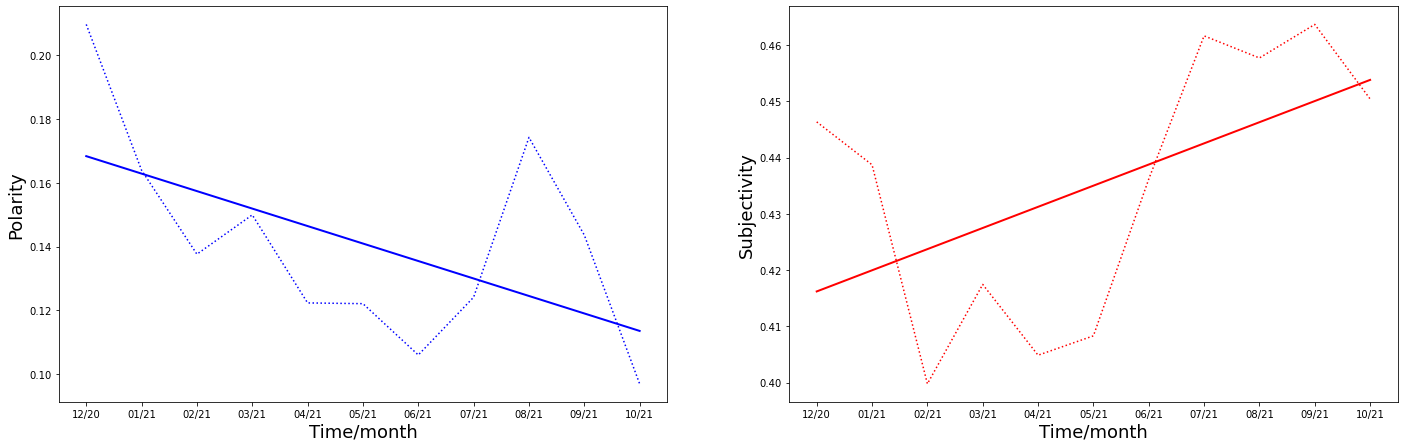

In [104]:
# Line displayed people's attitude change by time
fig = plt.figure(figsize=(24,16))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
plt.sca(ax1)
plt.plot(X,df_times['polarity'], color='blue',ls='dotted')
plt.plot(X,z1,c='blue',linewidth=2)
scale_ls = range(1,12)
index = ['12/20','01/21','02/21','03/21','04/21','05/21','06/21','07/21','08/21','09/21','10/21']
_ = plt.xticks(scale_ls, index)
plt.xlabel('Time/month',fontsize=18)
plt.ylabel("Polarity",fontsize=18)


plt.sca(ax2)
plt.plot(X,df_times['subjectivity'], color='red',ls='dotted')
plt.plot(X,z2,c='red',linewidth=2)
_ = plt.xticks(scale_ls, index)
plt.xlabel('Time/month',fontsize=18)
plt.ylabel("Subjectivity",fontsize=18)

## Topic Modeling

In [119]:
cv = CountVectorizer()
data_cv = cv.fit_transform(df_states.total_text)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
tdm = data_dtm.transpose()

In [120]:
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [121]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [126]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=30)
lda.print_topics()

[(0,
  '0.002*"covishield" + 0.001*"india" + 0.001*"narendramodi" + 0.001*"icmr" + 0.001*"pmoindia" + 0.001*"drreddys" + 0.001*"crore" + 0.001*"nhmassam" + 0.001*"covaxin" + 0.000*"modi"'),
 (1,
  '0.052*"moderna" + 0.030*"vaccine" + 0.015*"covid19" + 0.013*"shot" + 0.013*"got" + 0.011*"dose" + 0.009*"pfizer" + 0.009*"first" + 0.009*"vaccinated" + 0.008*"covaxin"')]

In [123]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [127]:
data_nouns_adj = pd.DataFrame(df_states.total_text.apply(nouns_adj))

In [128]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.total_text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index

In [129]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [134]:
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=40)
ldana.print_topics()

[(0,
  '0.006*"ocugen" + 0.006*"bharatbiotech" + 0.005*"world" + 0.004*"let" + 0.004*"heal" + 0.003*"time" + 0.003*"effective" + 0.003*"week" + 0.003*"johnsonandjohnson" + 0.003*"last"'),
 (1,
  '0.006*"bharatbiotech" + 0.006*"ocgn" + 0.004*"ocugen" + 0.004*"effective" + 0.004*"data" + 0.004*"sputnikv" + 0.003*"sinovac" + 0.003*"available" + 0.003*"time" + 0.003*"week"'),
 (2,
  '0.003*"sputnikvaccine" + 0.002*"sinopharm" + 0.001*"walkins" + 0.001*"welcome" + 0.001*"order" + 0.001*"sleep" + 0.001*"hundreds" + 0.001*"ass" + 0.001*"conditions" + 0.001*"mondayfriday"')]

#### We can see that the 3 topic regaring COVID-19 vaccines are:
        1. The healing effect of vaccines
        2. Vaccines developed by different countries and their effectivness
        3. How to be vaccined.